In [2]:
import snowflake.connector
import pandas as pd
import seaborn as sns
import plotly.express as px
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os
usr = os.environ['svc_user']
pwd = os.environ['svc_pwd']

warnings.filterwarnings('ignore')

In [3]:
def sf_connect():
    con = snowflake.connector.connect(  
        account = 'chewy.us-east-1',
        user = usr,
        password=pwd,
        autocommit = False,
        database= 'EDLDB',
        warehouse = 'IT_WH') #EDLDB_DSE_DEV
    return con

In [4]:
def exec_qry_batch(qry,numofdf=1):
    con = sf_connect()
    cur = con.cursor()
    try:
        batches = []
        cur.execute(qry,timeout=1200)
        for df in cur.fetch_pandas_batches():
            if((len(batches)<=numofdf) and (df.shape[0]>0)):
                batches.append(df)
            else:
                break
        return batches   
    except Exception as e:
        print(e)
    finally:
        cur.close()

In [5]:
def exec_qry_all(qry):
    con = sf_connect()
    cur = con.cursor()
    try:
        cur.execute(qry,timeout=1200)
        return cur.fetch_pandas_all()   
    except Exception as e:
        print(e)
    finally:
        cur.close()

In [6]:
qry = """SELECT *
FROM "EDLDB"."CDM"."PET_PROFILE" SAMPLE (10) SEED (45)
WHERE PET_TYPE = 'Dog' and PET_BREED_SIZE_TYPE IS NOT NULL"""

In [7]:
qry1 = """SELECT *
FROM "EDLDB"."CDM"."PET_PROFILE"
WHERE PET_TYPE = 'Dog' and PET_BREED_SIZE_TYPE IS NOT NULL
QUALIFY ROW_NUMBER() OVER (ORDER BY RANDOM()) <= 1000000
"""

---

### Dataset

Sampling with 10% data (~1.2M) with Dog as the only pet type

In [8]:
df = exec_qry_all(qry1)
df.head()

,PET_PROFILE_ID,CUSTOMER_ID,SUBMITTED_BY_CUSTOMER,SUBMITTED_BY_LOGON,PET_NAME,PET_TYPE,PET_BREED,PET_BREED_SIZE_TYPE,GENDER,WEIGHT_TYPE,...,TIME_UPDATED,WEIGHT,ALLERGY_COUNT,PHOTO_COUNT,MKTG_SAFE,PET_BREED_ID,PET_TYPE_ID,PET_NEW,FIRST_BIRTHDAY,SEVEN_BIRTHDAY
0,79265222,18720992,True,None,Floe Rida,Dog,Labrador Retriever,L,MALE,None,...,2021-06-16 04:36:10.601,63.0,0,0,False,461,1,False,2009-11-30,2015-11-30
1,79527574,108589065,True,None,Cleo,Dog,American Staffordshire Terrier,L,FMLE,None,...,2021-06-16 04:36:10.601,68.0,0,0,True,357,1,False,2018-02-05,2024-02-05
2,76640659,5574446,True,None,Dutch,Dog,UNKNOWN,UNK,MALE,None,...,2021-06-16 04:36:10.601,68.0,0,3,False,-1,1,False,2020-10-09,2026-10-09
3,2108898,44144739,True,None,Little Dude,Dog,UNKNOWN,UNK,UNKN,None,...,2018-10-11 13:48:32.971,0.0,0,0,True,-1,1,False,None,None
4,49716673,41539489,True,None,Shug,Dog,Pug,SM,MALE,None,...,2021-11-02 16:25:11.425,20.0,0,0,False,501,1,False,2016-11-02,2022-11-02


In [9]:
print("Columns :\n" ,df.columns)
print("Size: ",len(df))

Columns :
 Index(['PET_PROFILE_ID', 'CUSTOMER_ID', 'SUBMITTED_BY_CUSTOMER',
       'SUBMITTED_BY_LOGON', 'PET_NAME', 'PET_TYPE', 'PET_BREED',
       'PET_BREED_SIZE_TYPE', 'GENDER', 'WEIGHT_TYPE', 'SIZE_TYPE', 'BIRTHDAY',
       'BIRTHDAY_ESTIMATED', 'LIFE_STAGE', 'ADOPTED', 'ADOPTION_DATE',
       'STATUS', 'STATUS_REASON', 'TIME_CREATED', 'TIME_UPDATED', 'WEIGHT',
       'ALLERGY_COUNT', 'PHOTO_COUNT', 'MKTG_SAFE', 'PET_BREED_ID',
       'PET_TYPE_ID', 'PET_NEW', 'FIRST_BIRTHDAY', 'SEVEN_BIRTHDAY'],
      dtype='object')
Size:  1000000


In [10]:
df['PET_BREED_SIZE_TYPE'].value_counts(normalize = True).mul(100).round(2)

L      28.05
SM     19.58
M      18.35
XS     14.81
UNK    14.13
XL      2.84
G       2.23
Name: PET_BREED_SIZE_TYPE, dtype: float64

#### Null Values
Gaps in our data

In [11]:
# null_val = [print(col,df[col].isnull().sum()) for col in df.columns]
n,c = [], []
for col in df.columns:                  
    c.append(col), n.append(df[col].isnull().sum())
pd.DataFrame({'Columns': c, 'Null values': n})

,Columns,Null values
0,PET_PROFILE_ID,0
1,CUSTOMER_ID,0
2,SUBMITTED_BY_CUSTOMER,0
3,SUBMITTED_BY_LOGON,945700
4,PET_NAME,0
5,PET_TYPE,0
6,PET_BREED,0
7,PET_BREED_SIZE_TYPE,0
8,GENDER,0
9,WEIGHT_TYPE,997637


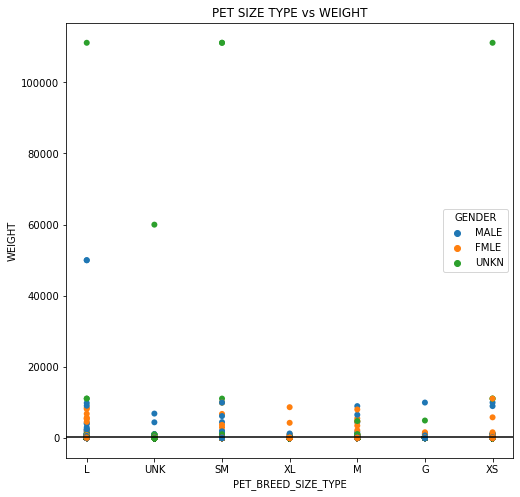

In [12]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x = "PET_BREED_SIZE_TYPE", y = "WEIGHT", hue="GENDER",
                linewidth=0,
                data=df, ax=ax).set_title("PET SIZE TYPE vs WEIGHT")
plt.axhline(350, color = 'black')
plt.show()

Calculating what % of users did not enter complete data

In [13]:
total_unique_cust = len(df['CUSTOMER_ID'].unique())
unkn_breeds = len(df[df['PET_BREED'] == 'UNKNOWN']['CUSTOMER_ID'].unique())
unkn_gender = len(df[df['GENDER'] == 'UNKN']['CUSTOMER_ID'].unique())
zero_weight = len(df[(df['WEIGHT'] == 0.0) | (df['WEIGHT'] >= 400)]['CUSTOMER_ID'].unique())
unkn_all = len(df[(df['PET_BREED'] == 'UNKNOWN') & (df['GENDER'] == 'UNKN') & ((df['WEIGHT'] == 0.0) | (df['WEIGHT'] >= 400))]['CUSTOMER_ID'].unique())
unkn_bday = len(df[df['BIRTHDAY'].isnull()]['CUSTOMER_ID'].unique())

print("% not entered Pet Breed - ",np.round((unkn_breeds/total_unique_cust)*100,2))
print("% not entered Pet Gender - ",np.round((unkn_gender/total_unique_cust)*100,2))
print("% not entered Pet Weight - ",np.round((zero_weight/total_unique_cust)*100,2))
print("% not entered All 3 - ",np.round((unkn_all/total_unique_cust)*100,2))
print("\n% not entered Pet Birthday - ",np.round((unkn_bday/total_unique_cust)*100,2))

% not entered Pet Breed -  14.4
% not entered Pet Gender -  10.69
% not entered Pet Weight -  12.72
% not entered All 3 -  6.84

% not entered Pet Birthday -  10.39


Cleaning data to remove incomplete values and filtering by WEIGHT < 400

In [14]:
df = df[(df['PET_BREED'] != 'UNKNOWN')&(df['GENDER'] != 'UNKN')&(df['WEIGHT'] > 0.0)&(df['BIRTHDAY'].notnull())]
df = df[df['WEIGHT'] < 400]
print("Size:",len(df))

Size: 788951


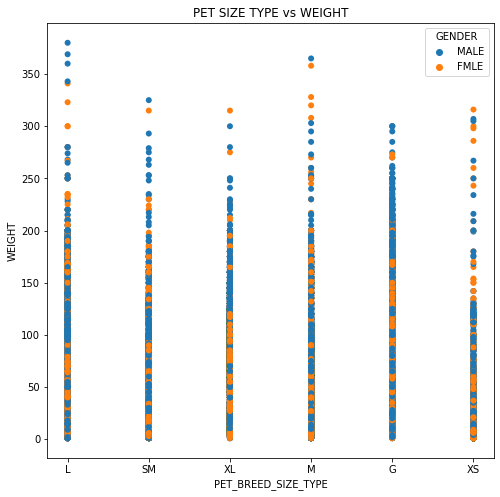

In [15]:
f, ax = plt.subplots(figsize=(8, 8))
graph = sns.scatterplot(x = "PET_BREED_SIZE_TYPE", y = "WEIGHT", hue="GENDER",
                linewidth=0,
                data=df, ax=ax).set_title("PET SIZE TYPE vs WEIGHT")
plt.show()

In [16]:
# n,c = [], []
# for col in df.columns:                  
#     c.append(col), n.append(df[col].isnull().sum())
# pd.DataFrame({'Columns': c, 'Null values': n})

In [17]:
# sns.displot(
#     df, x="WEIGHT", x = "PET_BREED_SIZE_TYPE", y = "GENDER",
#     binwidth=25, height=3, facet_kws=dict(margin_titles=True),
# )

---

#### Breed Type

In [18]:
breed_types = df['PET_BREED'].value_counts()
#print(breed_types)
#breed_types.drop(index=breed_types.index[0], axis=0, inplace=True)

breeds = list(breed_types.index[0:15])
breed_counts = list(breed_types[0:15])
breed_per = [np.round(x/sum(breed_types)*100,2) for x in breed_counts]

breed_size = []
breed_weight = []
for breed in breeds:
    breed_size.append(df[df['PET_BREED'] == breed][:1]['PET_BREED_SIZE_TYPE'].to_string(index=False))
    breed_weight.append(np.round(df[df['PET_BREED'] == breed]['WEIGHT'].mean(),2))

In [19]:
print(pd.DataFrame(list(zip(breeds, breed_counts, breed_per, breed_size, breed_weight)),
               columns =['Breed Name', 'Count', 'Percentage', 'Breed Size', 'Avg Weight']))
print("\nTotal number of breeds -",len(breed_types))
print("Top {} breeds make up {}% of the data".format(len(breeds),np.round(sum(breed_per),2)))


                   Breed Name  Count  Percentage Breed Size  Avg Weight
0          Labrador Retriever  80788       10.24          L       70.47
1             German Shepherd  45444        5.76          L       73.25
2   American Pit Bull Terrier  37433        4.74          M       60.48
3            Golden Retriever  33041        4.19          L       67.24
4                   Chihuahua  32627        4.14         XS        9.55
5           Yorkshire Terrier  27570        3.49         XS        8.77
6                    Shih Tzu  27508        3.49         XS       13.65
7         Australian Shepherd  22977        2.91          M       40.14
8                Goldendoodle  22475        2.85         SM       44.68
9                       Boxer  18769        2.38          L       62.57
10                  Dachshund  16627        2.11         SM       15.21
11             Siberian Husky  15093        1.91          M       53.59
12                     Beagle  15070        1.91         SM     

**Recommendation**: Working with the top x breeds covers a majority of the data and can be a good starting point to associating breeds(and their breed-sizes) to products

---

#### Pet Breed Size Type

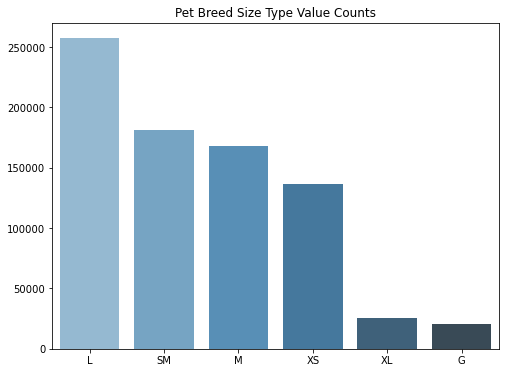

L     32.61
SM    22.98
M     21.30
XS    17.28
XL     3.28
G      2.56
Name: PET_BREED_SIZE_TYPE, dtype: float64


In [20]:
df_index = df['PET_BREED_SIZE_TYPE'].value_counts().index
df_counts = list(df['PET_BREED_SIZE_TYPE'].value_counts())
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=df_index, y=df_counts, palette="Blues_d").set_title("Pet Breed Size Type Value Counts")
plt.show()
print(df['PET_BREED_SIZE_TYPE'].value_counts(normalize = True).mul(100).round(2))

Avg weight for each breed size type
PET_BREED_SIZE_TYPE
G     111.73
L      66.34
M      47.84
SM     23.34
XL     78.97
XS     10.92
Name: WEIGHT, dtype: float64


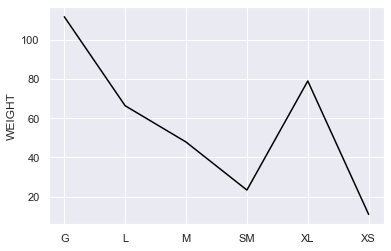

In [21]:
print("Avg weight for each breed size type")
avg_wgt_size_type = np.round(df.groupby(['PET_BREED_SIZE_TYPE'])['WEIGHT'].mean(),2)
print(avg_wgt_size_type)

sns.set_theme(style="darkgrid")
sns.lineplot(x = ['G','L','M','SM','XL','XS'], y = avg_wgt_size_type, color = 'black')
plt.show()

In [22]:
print("Unique pet breeds in each size type")
#print(df.groupby(['PET_BREED_SIZE_TYPE'])['PET_BREED'].agg(['unique','nunique']))

uni_breed = df.groupby(['PET_BREED_SIZE_TYPE'])['PET_BREED'].unique()
nuni_breed = df.groupby(['PET_BREED_SIZE_TYPE'])['PET_BREED'].nunique()
nuni_per =  np.round(nuni_breed/len(df['PET_BREED'].unique())*100,2)
data_per = np.round(df.groupby(['PET_BREED_SIZE_TYPE'])['PET_BREED'].count()/len(df)*100,2)

pd.DataFrame(list(zip(['G','L','M','SM','XL','XS'],uni_breed, nuni_breed, nuni_per, data_per)),
               columns =['Pet Breed size type','Unique Breeds', 'Unique Breeds Count', 'Unique Breeds percentage', 'Percentage of total data'])

Unique pet breeds in each size type


,Pet Breed size type,Unique Breeds,Unique Breeds Count,Unique Breeds percentage,Percentage of total data
0,G,"[Mastiff, Saint Bernard, Great Dane, Newfoundl...",25,7.12,2.56
1,L,"[Labrador Retriever, American Staffordshire Te...",93,26.50,32.61
2,M,"[Siberian Husky, English Bulldog, American Pit...",108,30.77,21.30
3,SM,"[Pug, Rat Terrier, Corgi, Beagle, Toy Poodle, ...",81,23.08,22.98
4,XL,"[Rottweiler, Bernese Mountain Dog, Anatolian S...",15,4.27,3.28
5,XS,"[Chihuahua, Yorkshire Terrier, Shih Tzu, Pomer...",29,8.26,17.28


**Recommendation**: Working directly with specific pet breed size types also allows us to access a majority of the data which can be a good starting point <br>
Ex: SM, M and L make up 76.8% of the total data which also covers 80.33% of all unique pet breeds

---

Q: PDM.PRODUCT has a 'BREED_SIZE' column associating products to breed sizes. <br>
Obj: To impute the missing values(54.82%) / To perform a check on the existing values

---

---

---

#### Gender
Gender only gives an option of Male/Female while registering for pet profile. How do we have UNKN gender counts as well?

Value Counts: 
 MALE    404807
FMLE    384144
Name: GENDER, dtype: int64


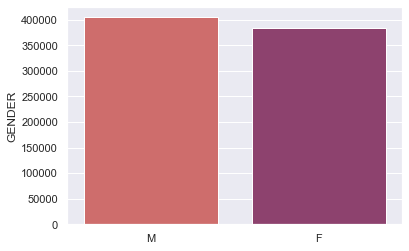

In [23]:
print("Value Counts: \n", df['GENDER'].value_counts())

sns.barplot(x = ['M','F'], y =df['GENDER'].value_counts(), palette="flare")
plt.show()

In [24]:
male,female = [], []
for breed_name in breeds:
    male.append(df[df['PET_BREED'] == breed_name]['GENDER'].value_counts()[0])
    female.append(df[df['PET_BREED'] == breed_name]['GENDER'].value_counts()[1])
    #unknown.append(df[df['PET_BREED'] == breed_name]['GENDER'].value_counts()[2])

print("Gender counts for Top 15 breeds")
pd.DataFrame(list(zip(breeds, male, female)),
               columns =['Breed Name', 'Male Count', 'Female Count'])

Gender counts for Top 15 breeds


,Breed Name,Male Count,Female Count
0,Labrador Retriever,41514,39274
1,German Shepherd,23368,22076
2,American Pit Bull Terrier,19222,18211
3,Golden Retriever,17775,15266
4,Chihuahua,17546,15081
5,Yorkshire Terrier,13786,13784
6,Shih Tzu,14165,13343
7,Australian Shepherd,11881,11096
8,Goldendoodle,12192,10283
9,Boxer,9571,9198


#### Customer Id

In [25]:
#Number of repeated customers
len(df['CUSTOMER_ID']) - len(df['CUSTOMER_ID'].unique())

20564

---

---

---

* Join ORDER_LINE_PROMOTION_USAGE with PET_PROFILE on customer_id
* Join ORDER_LINE_PROMOTION_USAGE with PRODUCT on product_id
* Filter by PET_TYPE = 'Dog' and remove NULLS in PET_BREED_SIZE_TYPE and SIZE_TYPE
* Select a subset of 3.53M values out of ~353M values (1%)

In [54]:
    qry2 = """SELECT 
    OL.CUSTOMER_ID, OL.PRODUCT_ID, OL.ORDER_ID, OL.PRODUCT_NAME, OL.MERCH_CLASSIFICATION1, OL.MERCH_CLASSIFICATION2, 
    PP.PET_TYPE, PP.PET_BREED, PP.WEIGHT, PP.BIRTHDAY, PP.SIZE_TYPE, PP.PET_BREED_SIZE_TYPE, 
    P.BREED_SIZE, P.LIFE_STAGE

    FROM "EDLDB"."CDM"."ORDER_LINE_PROMOTION_USAGE" AS OL
    JOIN "EDLDB"."CDM"."PET_PROFILE" AS PP ON PP.CUSTOMER_ID = OL.CUSTOMER_ID
    JOIN "EDLDB"."PDM"."PRODUCT" AS P ON P.PRODUCT_ID = OL.PRODUCT_ID
    WHERE PP.PET_TYPE = 'Dog' and PP.PET_BREED_SIZE_TYPE IS NOT NULL AND PP.PET_BREED_SIZE_TYPE <> 'UNK'
    QUALIFY ROW_NUMBER() OVER (ORDER BY RANDOM()) <= 3530000
"""

In [56]:
data = exec_qry_all(qry2)
data.head()

,CUSTOMER_ID,PRODUCT_ID,ORDER_ID,PRODUCT_NAME,MERCH_CLASSIFICATION1,MERCH_CLASSIFICATION2,PET_TYPE,PET_BREED,WEIGHT,BIRTHDAY,SIZE_TYPE,PET_BREED_SIZE_TYPE,BREED_SIZE,LIFE_STAGE
0,9975265,33281,330037264,Natural Balance L.I.T. Limited Ingredient Grai...,Consumables,Core Treats,Dog,Chihuahua,12.0,2005-03-23,XS,XS,Extra Small & Toy Breeds;Giant Breeds;Large Br...,Adult
1,63239544,123726,386878638,Hill's Science Diet Adult Sensitive Stomach & ...,Consumables,Core Food,Dog,Labrador Retriever,70.0,2015-10-30,L,L,Extra Small & Toy Breeds;Small Breeds,Adult
2,34744230,36660,351999353,"Nature's Recipe Grain-Free Salmon, Sweet Potat...",Consumables,Core Food,Dog,American Bully,60.0,2019-08-21,L,L,All Breeds;Large Breeds;Medium Breeds;Small Br...,Adult
3,10880701,115622,181647946,"Bones & Chews Made in USA Elk Antler Dog Chew,...",Consumables,Core Treats,Dog,Golden Retriever,95.0,2016-05-30,L,L,Giant Breeds;Large Breeds,Adult
4,25755073,172989,1095896256,"Interceptor Chewable Tablet for Dogs, 11-25 lb...",Healthcare,Pharmacy,Dog,Doberman Pinscher,109.0,2016-05-30,L,L,Small Breeds,None


In [92]:
data['CUSTOMER_ID'].nunique()

1609025

---

What is the order % vs breed size?

In [121]:
print("% of orders made by customers having breed size:\n", np.round(data['PET_BREED_SIZE_TYPE'].value_counts()/len(data)*100,2))

% of orders made by customers having breed size:
 L     35.93
M     21.16
SM    20.74
XS    14.51
XL     3.96
G      3.70
Name: PET_BREED_SIZE_TYPE, dtype: float64


---

What are the most ordered products?

In [59]:
c = data[['PRODUCT_ID','PRODUCT_NAME']].value_counts()[0:10]
p = data[['PRODUCT_ID','PRODUCT_NAME']].value_counts(normalize=True).mul(100).round(2)[0:10]
print(pd.concat([c,p], axis=1, keys=['counts', '%']))
print("\nTop 10 products make up {}% of all orders".format(p.sum().round(2)))

                                                               counts     %
PRODUCT_ID PRODUCT_NAME                                                    
173047     Apoquel Tablets for Dogs, 16-mg, 1 tablet            18277  0.52
173234     Heartgard Plus Chew for Dogs, 51-100 lbs, (Brow...   15669  0.44
32041      Blue Buffalo Life Protection Formula Adult Chic...   15517  0.44
128666     Purina Pro Plan Adult Sensitive Skin & Stomach ...   14969  0.42
135821     American Journey Salmon & Sweet Potato Recipe G...   13958  0.40
53157      SmartBones SmartSticks Peanut Butter Chews Dog ...   12877  0.36
173230     Heartgard Plus Chew for Dogs, up to 25 lbs, (Bl...   11892  0.34
152973     American Journey Peanut Butter Recipe Grain-Fre...   11139  0.32
181320     Taste of the Wild High Prairie Grain-Free Dry D...   10533  0.30
173254     NexGard Chew for Dogs, 60.1-121 lbs, (Red Box),...    9646  0.27

Top 10 products make up 3.81% of all orders


What are the most ordered products for any size type?

In [60]:
def Most_ordered(size_type, n = 10):
    c = data[data['PET_BREED_SIZE_TYPE'] == size_type][['PRODUCT_ID','PRODUCT_NAME']].value_counts()[0:n]
    p = data[data['PET_BREED_SIZE_TYPE'] == size_type][['PRODUCT_ID','PRODUCT_NAME']].value_counts(normalize=True).mul(100).round(2)[0:n]
    print(pd.concat([c,p], axis=1, keys=['counts', '%']))
    print("\nTop {} products make up {}% of all orders".format(n, p.sum().round(2)))

In [61]:
#Mention size_type in '' and top n products to be displayed 
Most_ordered('G',15)

                                                               counts     %
PRODUCT_ID PRODUCT_NAME                                                    
32062      Blue Buffalo Life Protection Formula Large Bree...     929  0.71
44929      Diamond Naturals Large Breed Adult Chicken & Ri...     916  0.70
141446     Hill's Science Diet Adult Large Breed Dry Dog F...     793  0.61
128666     Purina Pro Plan Adult Sensitive Skin & Stomach ...     737  0.56
52393      Purina Pro Plan Adult Giant Breed Formula Dry D...     696  0.53
37558      Purina ONE Natural Large Breed +Plus Formula Dr...     680  0.52
170136     Purina ONE Natural Large Breed +Plus Formula Dr...     673  0.52
37580      Purina ONE Natural High Protein +Plus Large Bre...     654  0.50
52425      Purina Pro Plan Large Breed High Protein Chicke...     648  0.50
182003     Purina Pro Plan Adult Sensitive Skin & Stomach ...     643  0.49
47272      Iams Adult Large Breed Real Chicken High Protei...     617  0.47
173047     A

---

What is the count of each size type of pets for a particular product?

In [62]:
def Size_type(product_id):
    print("Product ID {} - {}".format(product_id, list(data.loc[data['PRODUCT_ID'] == product_id,'PRODUCT_NAME'])[0]))
    print("Customers ordering product {} have:".format(product_id))
    print(data[data['PRODUCT_ID'] == product_id]['PET_BREED_SIZE_TYPE'].value_counts())

In [63]:
Size_type(52393)

Product ID 52393 - Purina Pro Plan Adult Giant Breed Formula Dry Dog Food, 34-lb bag
Customers ordering product 52393 have:
G     696
XL    155
L     137
SM     51
M      49
XS     38
Name: PET_BREED_SIZE_TYPE, dtype: int64


---

What number of products are common between two sizes?

In [64]:
print("All sizes",data['PRODUCT_ID'].nunique())
size = ['XS','SM','M','L','XL','G']
for x in size:
    print(x, data[data['PET_BREED_SIZE_TYPE'] == x]['PRODUCT_ID'].nunique())

All sizes 63199
XS 34258
SM 39191
M 38149
L 42583
XL 18334
G 16298


In [97]:
def common_prod(size1, size2):
    len1 = data[data['PET_BREED_SIZE_TYPE'] == size1]['PRODUCT_ID'].nunique()
    len2 = data[data['PET_BREED_SIZE_TYPE'] == size2]['PRODUCT_ID'].nunique()
    len12 = data[(data['PET_BREED_SIZE_TYPE'] == size1) | (data['PET_BREED_SIZE_TYPE'] == size2)]['PRODUCT_ID'].nunique()
    lenun = len1+len2 - len12
    print("{} has {}% common values with {}".format(size1, np.round(lenun/len1*(100),2), size2))
    print("{} has {}% common values with {}".format(size2, np.round(lenun/len2*(100),2), size1))
    print(len1, len2, len12,lenun)

In [98]:
common_prod('M','L')

M has 77.83% common values with L
L has 69.73% common values with M
38149 42583 51040 29692


---

Table for all breed sizes

In [99]:
l1 = []
for i in data['PET_BREED_SIZE_TYPE'].unique():
    for j in data['PET_BREED_SIZE_TYPE'].unique():
        len1 = data[data['PET_BREED_SIZE_TYPE'] == i]['PRODUCT_ID'].nunique()
        len2 = data[data['PET_BREED_SIZE_TYPE'] == j]['PRODUCT_ID'].nunique()
        len12 = data[(data['PET_BREED_SIZE_TYPE'] == i) | (data['PET_BREED_SIZE_TYPE'] == j)]['PRODUCT_ID'].nunique()
        lenun = len1+len2 - len12
        #print("{} has {}% common products with {}".format(i, np.round(lenun/len2*(100),2), j))
        l1.append(np.round(lenun/len1*(100),2))

table = pd.DataFrame(list(zip(l1[0:6], l1[6:12], l1[12:18], l1[18:24], l1[24:30], l1[30:36])), columns = data['PET_BREED_SIZE_TYPE'].unique(), index = data['PET_BREED_SIZE_TYPE'].unique())
table

,XS,L,G,M,SM,XL
XS,100.00,61.92,83.18,65.91,66.27,82.52
L,76.97,100.00,91.90,77.83,74.84,90.81
G,39.57,35.17,100.00,38.07,36.45,59.48
M,73.39,69.73,89.11,100.00,71.01,88.03
SM,75.81,68.88,87.64,72.95,100.00,87.24
XL,44.16,39.10,66.91,42.31,40.81,100.00


Table is read columnn wise <br>
(row wise in the doc)

---

---

MC1 %

In [122]:
data['MERCH_CLASSIFICATION1'].value_counts(normalize = True).mul(100).round(2)

Consumables       66.13
Healthcare        20.99
Hard Goods         6.68
Premium            3.37
Specialty          2.67
Gift Cards         0.17
Virtual Bundle     0.00
Name: MERCH_CLASSIFICATION1, dtype: float64

In [110]:
def mc(size1,size2, choice = 'MC1'):
    list1 = data[data['PET_BREED_SIZE_TYPE'] == size1]['PRODUCT_ID'].unique()
    list2 = data[data['PET_BREED_SIZE_TYPE'] == size2]['PRODUCT_ID'].unique()
    print("Number of products of {}: {}".format(size1,len(list1)))
    print("Number of products of {}: {}".format(size2,len(list2)))

    common_prod_id = list(set(list1).intersection(list2))
    print("Number of common products:",len(common_prod_id))

    #list1+list2-2(common_prod_id)
    disjoint_prod_id = list(set(list1)^set(list2))
    print("Number of different products:",len(disjoint_prod_id))

    print("\nCommon product ids")
    if choice == 'MC1':
        print(data[(data['PRODUCT_ID'].isin(common_prod_id))]['MERCH_CLASSIFICATION1'].value_counts(normalize = True).mul(100).round(2))
    elif choice == 'MC2':
        print(data[(data['PRODUCT_ID'].isin(common_prod_id))][['MERCH_CLASSIFICATION1','MERCH_CLASSIFICATION2']].value_counts(normalize = True).mul(100).round(2).sort_index())

    print("\nUnique product ids")
    if choice == 'MC1':
        print(data[(data['PRODUCT_ID'].isin(disjoint_prod_id))]['MERCH_CLASSIFICATION1'].value_counts(normalize = True).mul(100).round(2))
    elif choice == 'MC2':
        print(data[(data['PRODUCT_ID'].isin(disjoint_prod_id))][['MERCH_CLASSIFICATION1','MERCH_CLASSIFICATION2']].value_counts(normalize = True).mul(100).round(2).sort_index())

In [120]:
mc('M','L','MC2')

Number of products of M: 38149
Number of products of L: 42583
Number of common products: 29692
Number of different products: 21348

Common product ids
MERCH_CLASSIFICATION1  MERCH_CLASSIFICATION2       
Consumables            Core Food                       39.83
                       Core Treats                     25.10
                       Litter                           2.06
Gift Cards             Chewy Cash                       0.00
                       Digital Gift Cards               0.01
                       Promotional Cards                0.16
Hard Goods             Apparel & People Products        0.14
                       Beauty & Grooming                0.69
                       Beds & Furniture                 0.20
                       Bowls & Feeders                  0.15
                       Containment & Gear               0.22
                       Leashes, Collars & Harnesses     0.20
                       Personalized                     0.06
    

In [71]:
#data[((data['PET_BREED_SIZE_TYPE'] == 'L') | (data['PET_BREED_SIZE_TYPE'] == 'M')) & (data['PRODUCT_ID'].isin(disjoint_prod_id))]['MERCH_CLASSIFICATION1'].value_counts(normalize = True).mul(100).round(2)
#data[((data['PET_BREED_SIZE_TYPE'] == 'L') | (data['PET_BREED_SIZE_TYPE'] == 'M')) & (data['PRODUCT_ID'].isin(disjoint_prod_id))].groupby(['MERCH_CLASSIFICATION1'])['MERCH_CLASSIFICATION2'].value_counts(normalize = True).mul(100).round(2)